In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [2]:
# ----------------------
# Step 1: Import Libraries
# ----------------------
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

In [ ]:


# ----------------------
# Step 2: Loading and Preprocess Data
# ----------------------

# Training Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizes pixel values from the range [0, 255] to [0, 1] by dividing every pixel by 255.
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    zoom_range=0.2,
)


training_set = train_datagen.flow_from_directory(
    'archive/Train',
    target_size=(128, 128),  # Resize to 128x128 pixels (Compatibility to MobileNetV2)
    batch_size=64,
    class_mode='sparse',     # Sparse categorical labels, returns labels as integers
    color_mode='rgb'   # RGB input because MobileNetV2 expects 3-channel RGB input
)


Found 27455 images belonging to 24 classes.


In [4]:
# Test Data Preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    'archive/Test',
    target_size=(128, 128),  # Match training size
    batch_size=64,
    class_mode='sparse',     # Sparse categorical labels
    color_mode='rgb'
)

Found 7172 images belonging to 24 classes.


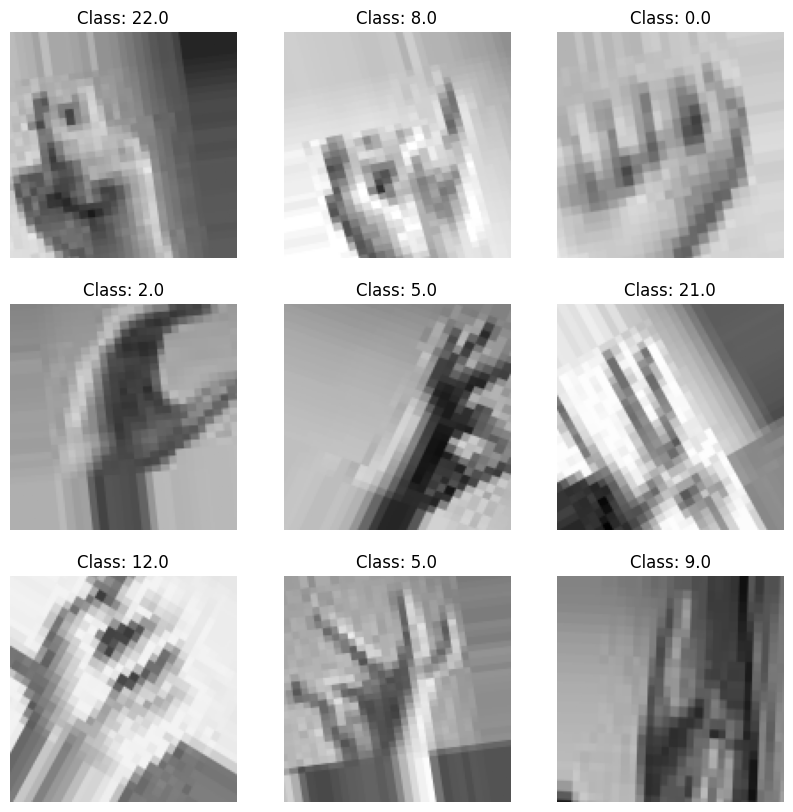

In [5]:
# Display some augmented images
x_batch, y_batch = next(training_set)  # Get a batch of training data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')  # Use `cmap='gray'` for grayscale
    plt.title(f'Class: {y_batch[i]}')  # Sparse labels are integers
  # Adjust title for one-hot or sparse
    plt.axis('off')
plt.show()


In [ ]:
# ----------------------
# Step 3: Load Pretrained Model (Feature Extractor)
# ----------------------

# Load MobileNetV2 pretrained on ImageNet
base_model = MobileNetV2(
    input_shape=(128, 128, 3),  # MobileNetV2 expects 3-channel RGB input
    include_top=False,          # Exclude the classification head, Excludes dense layer, acts as feature extractor
    weights='imagenet'          # Use pretrained weights
)

# Freeze the base model's layers to prevent training
base_model.trainable = False


In [ ]:
# ----------------------
# Step 4: Build the Model
# ----------------------

# Add custom layers on top of the pretrained base model
model = Sequential([

    # Use the pretrained base model as a fixed feature extractor
    base_model,  # Pretrained MobileNetV2 without the classification head
    GlobalAveragePooling2D(),  # Replace Flatten with GAP to reduce overfitting

    # Custom dense layers for classification
    Dense(256, activation='relu'),
    BatchNormalization(), # Normalizes the inputs to the dense layer, speeding up training and stabilizing the learning process.
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(24, activation='softmax')  # 24 classes for ASL
])



In [ ]:
# ----------------------
# Step 5: Compile the Model
# ----------------------

model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for stability
    loss='sparse_categorical_crossentropy', # Labels are integers
    metrics=['accuracy']
)

In [ ]:
# Inspect a batch of data from the generator
# To confirm shape and format 
x_batch, y_batch = next(training_set)
print("Input batch shape (x_batch):", x_batch.shape)
print("Label batch shape (y_batch):", y_batch.shape)
training_set.reset()
test_set.reset()

y_batch = np.argmax(y_batch, axis=-1)


Input batch shape (x_batch): (64, 128, 128, 3)
Label batch shape (y_batch): (64,)


In [11]:
# ----------------------
# Step 6: Train the Model
# ----------------------

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)
'''
Dynamically reduces the learning rate when the validation loss plateaus (does not improve for patience epochs).
Helps the model converge better in later epochs by fine-tuning weights more cautiously.
'''

reduce_lr = ReduceLROnPlateau( # Dynamic adjustment of the learning rate during training can lead to better convergence.
    monitor='val_loss',
    factor=0.5,   # Reduce the learning rate by half
    patience=3,   # If no improvement for 3 epochs
    min_lr=1e-6   # Set a minimum learning rate
)
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=5, 
#     restore_best_weights=True
# )

# Train the model
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=25,
    # class_weight = class_weights,
    callbacks=[reduce_lr, model_checkpoint]
)

c:\Users\Boyigop-Laptop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 331s 763ms/step - accuracy: 0.0385 - loss: 4.8970 - val_accuracy: 0.0510 - val_loss: 3.4801 - learning_rate: 1.0000e-05
Epoch 2/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 87s 203ms/step - accuracy: 0.0536 - loss: 4.4686 - val_accuracy: 0.0858 - val_loss: 3.2603 - learning_rate: 1.0000e-05
Epoch 3/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 88s 205ms/step - accuracy: 0.0703 - loss: 4.0899 - val_accuracy: 0.1157 - val_loss: 3.0447 - learning_rate: 1.0000e-05
Epoch 4/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 89s 208ms/step - accuracy: 0.0908 - loss: 3.8334 - val_accuracy: 0.1496 - val_loss: 2.8776 - learning_rate: 1.0000e-05
Epoch 5/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 87s 202ms/step - accuracy: 0.1012 - loss: 3.6238 - val_accuracy: 0.1874 - val_loss: 2.7416 - learning_rate: 1.0000e-05
Epoch 6/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 89s 206ms/step - accuracy: 0.1239 - loss: 3.4539 - val_accuracy: 0.2158 - val_loss: 2.6367 - learning_rate: 1.0000e-05
Epoch 7/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 93s 2

In [ ]:
# ----------------------
# Step 7: Fine Tuning
# ----------------------


# Unfreeze the base model for fine-tuning
base_model.trainable = True # Unfreeze to slightly adjust the pretrained weights


# Unfreezing deeper layers since they capture high-level features relevant
for layer in base_model.layers[:-50]:  # Freeze all layers except the last 50
    layer.trainable = False

In [13]:
# Recompiling again after changing trainable attributes
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # incerease LR since  frozen layers have already stabilized.
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [14]:
# Fine-tune the model
history_finetune = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,  # Train for a few more epochs
    callbacks=[model_checkpoint]  # Apply early stopping
)


Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 152s 331ms/step - accuracy: 0.3329 - loss: 2.3062 - val_accuracy: 0.5690 - val_loss: 1.3374
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 145s 337ms/step - accuracy: 0.7052 - loss: 0.9156 - val_accuracy: 0.6531 - val_loss: 1.1168
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 147s 342ms/step - accuracy: 0.8439 - loss: 0.4997 - val_accuracy: 0.6821 - val_loss: 0.8702
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 147s 343ms/step - accuracy: 0.9071 - loss: 0.3089 - val_accuracy: 0.7798 - val_loss: 0.6867
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 152s 355ms/step - accuracy: 0.9447 - loss: 0.2061 - val_accuracy: 0.9294 - val_loss: 0.2108
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 147s 343ms/step - accuracy: 0.9601 - loss: 0.1491 - val_accuracy: 0.8919 - val_loss: 0.2955
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 146s 341ms/step - accuracy: 0.9636 - loss: 0.1293 - val_accuracy: 0.9520 - val_loss: 0.1415
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 150s 349ms/step - accuracy: 0.9742 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2

<Figure size 1000x1000 with 0 Axes>

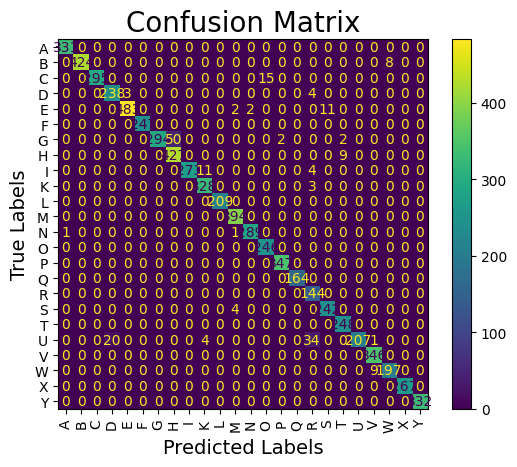

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      0.98      0.99       432
           C       1.00      0.95      0.98       310
           D       0.92      0.97      0.95       245
           E       0.99      0.97      0.98       498
           F       1.00      1.00      1.00       247
           G       1.00      0.84      0.92       348
           H       0.90      0.98      0.94       436
           I       1.00      0.95      0.97       288
           K       0.96      0.99      0.97       331
           L       1.00      1.00      1.00       209
           M       0.98      1.00      0.99       394
           N       0.99      0.99      0.99       291
           O       0.94      1.00      0.97       246
           P       0.99      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       0.76      1.00      0.86       144
   

In [15]:

# -------------------------------
# Predict on Entire Test Dataset
# -------------------------------

# Initialize arrays for true labels and predictions
true_labels = []
predicted_labels = []

# Loop through the test dataset in batches
for images, labels in test_set:
    predictions = model.predict(images)  # Get predictions
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
    true_labels.extend(labels)  # Store true labels
    predicted_labels.extend(predicted_classes)  # Store predicted labels

    # Break after processing all test data (important for generators)
    if len(true_labels) >= test_set.samples:
        break

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# -------------------------------
# 1. Confusion Matrix
# -------------------------------

# Compute and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(training_set.class_indices.keys()))

# Adjust figure size before plotting
plt.figure(figsize=(10,10))  # Adjust the width and height as needed
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Add title and show plot
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# -------------------------------
# 2. Classification Report
# -------------------------------
# Generate classification metrics
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=list(training_set.class_indices.keys())))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


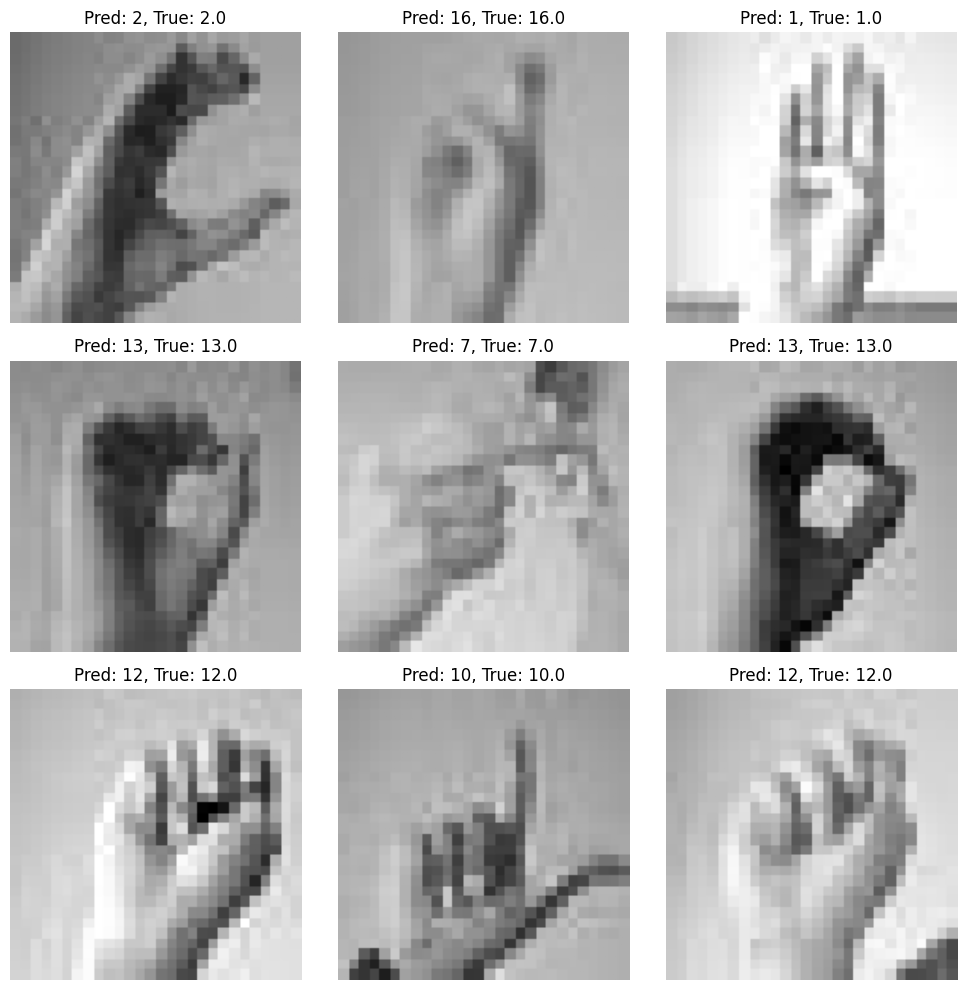

In [16]:
# Display predictions on test images
plt.figure(figsize=(10, 10))
test_images, test_labels = next(test_set)  # Get a batch of test data
predictions = model.predict(test_images)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    plt.title(f'Pred: {predicted_label}, True: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

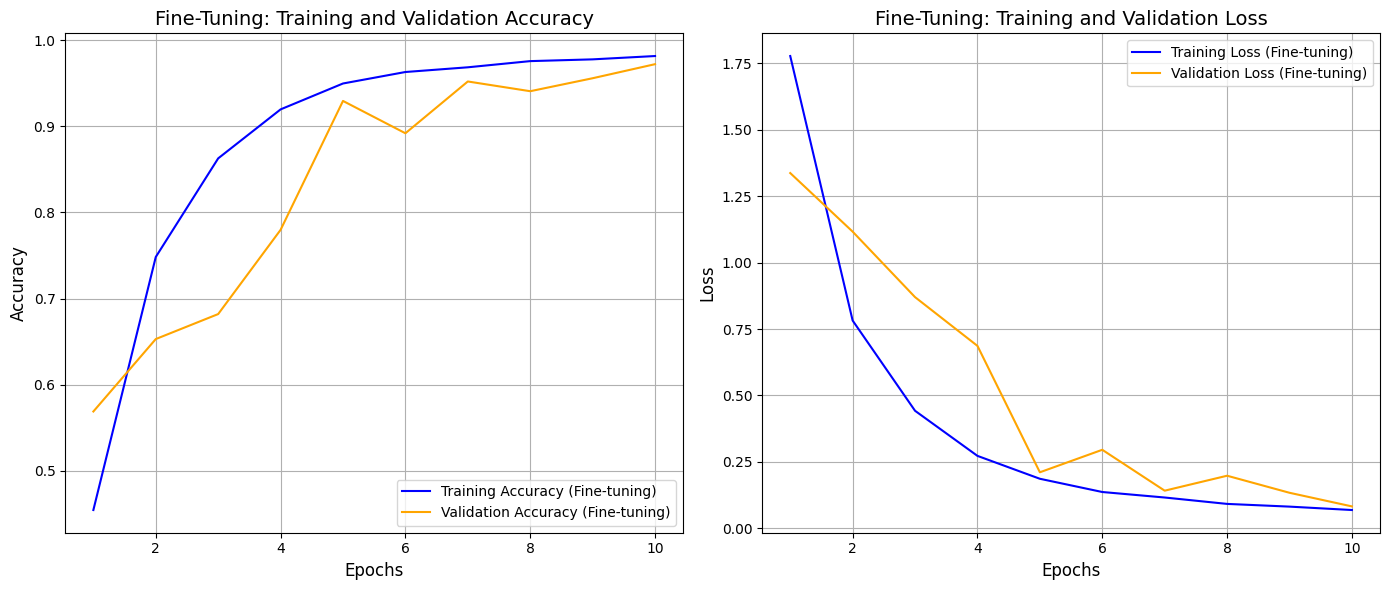

In [17]:
import matplotlib.pyplot as plt


history_finetune_dict = history_finetune.history

# Extract accuracy and loss for training and validation
fine_tune_train_acc = history_finetune_dict['accuracy']
fine_tune_val_acc = history_finetune_dict['val_accuracy']
fine_tune_train_loss = history_finetune_dict['loss']
fine_tune_val_loss = history_finetune_dict['val_loss']

# Define the number of epochs
fine_tune_epochs = range(1, len(fine_tune_train_acc) + 1)

# Set figure size and style
plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs, fine_tune_train_acc, label='Training Accuracy (Fine-tuning)', color='blue')
plt.plot(fine_tune_epochs, fine_tune_val_acc, label='Validation Accuracy (Fine-tuning)', color='orange')
plt.title('Fine-Tuning: Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs, fine_tune_train_loss, label='Training Loss (Fine-tuning)', color='blue')
plt.plot(fine_tune_epochs, fine_tune_val_loss, label='Validation Loss (Fine-tuning)', color='orange')
plt.title('Fine-Tuning: Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()


In [18]:
# Save the model after training
model.save('asl_recognition_model.h5')
print("Model saved to 'asl_recognition_model.h5'.")

Model saved to 'asl_recognition_model.h5'.


In [21]:
# ----------------------
# Step 11: Predict on Outside Data
# ----------------------
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_outside_image(image_path, model, class_indices):
    # Step 1: Load and preprocess the image
    test_image = image.load_img(image_path, target_size=(128, 128), color_mode='rgb')  # Resize to match model input
    test_image = image.img_to_array(test_image) / 255.0  # Normalize to [0, 1]
    test_image = np.expand_dims(test_image, axis=0)      # Add batch dimension

    # Step 2: Predict
    result = model.predict(test_image)
    predicted_class_index = np.argmax(result)

    # Step 3: Map prediction back to class label
    reverse_class_indices = {v: k for k, v in class_indices.items()}
    predicted_label = reverse_class_indices[predicted_class_index]

    # Step 4: Combine class labels and probabilities, then sort and select top 5
    probabilities = {reverse_class_indices[i]: prob for i, prob in enumerate(result[0])}
    top_5_predictions = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:5]

    # Step 5: Print the predicted label and top 5 class probabilities
    print(f"Predicted Label: {predicted_label}")
    print("Top 5 Class Probabilities:")
    for label, prob in top_5_predictions:
        print(f"  {label}: {prob:.2f}")

# Example usage
predict_outside_image('archive/Prediction/A.jpg', model, training_set.class_indices)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: A
Top 5 Class Probabilities:
  A: 0.68
  S: 0.30
  Y: 0.01
  N: 0.00
  I: 0.00
